In [ ]:
import gmsh
import numpy as np
from dataclasses import dataclass, asdict
import numpy.typing as npt
import matplotlib.pyplot as plt
import pickle
from typing import Self


In [2]:
@dataclass(frozen=True, slots=True)
class Mesh:
    num_elements: int  # K in Allan's notation
    num_nodes: int     # Nv in Allan's notation
    num_faces: int     # Nfaces in Allan's notation
    V_x: npt.NDArray[np.float64]  # Node x-coordinates, VX in Allan's notation
    V_y: npt.NDArray[np.float64]  # Node y-coordinates, VY in Allan's notation

    # Element to vertex connectivity
    # Elements this array are node_tags, NOT INDICES!
    EtoV_tags: npt.NDArray[np.int64]   # Element to vertex connectivity, EToV in Allan's notation
    # Elements in this array are indices (zero-based)
    EtoV: npt.NDArray[np.int64]   # Element to vertex connectivity, EToV in Allan's notation

    # Node-index mapping
    node_to_idx: dict[int, int]  # Maps node tags to zero-based indices

    def save(self, filename: str) -> None:
        with open(filename, 'wb') as f:
            pickle.dump(asdict(self), f)

    @classmethod
    def load(cls, filename: str) -> Self:
        with open(filename, 'rb') as f:
            return cls(**pickle.load(f))

In [3]:
# import sys

# # Initialize Gmsh
# gmsh.initialize()

# try:
#     # Create a new model named "circle"
#     gmsh.model.add("circle")

#     # Define parameters
#     radius = 1.0       # Radius of the circle
#     mesh_size = 0.5    # Approximate mesh element size

#     # Use the OpenCASCADE (OCC) geometry kernel
#     # Add a circle centered at (0, 0, 0) with radius `radius`
#     # The resulting curve has tag 1
#     gmsh.model.occ.addCircle(0, 0, 0, radius, 1)

#     # Create a curve loop from the circle (curve tag 1)
#     # The resulting curve loop has tag 1
#     gmsh.model.occ.addCurveLoop([1], 1)

#     # Create a plane surface from the curve loop (loop tag 1)
#     # The resulting surface has tag 1
#     gmsh.model.occ.addPlaneSurface([1], 1)

#     # Synchronize the OCC geometry with the Gmsh model
#     gmsh.model.occ.synchronize()

#     # Set the global mesh size
#     # This will be used as the target size for mesh elements
#     gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)

#     # Generate the 2D mesh (dim=2)
#     gmsh.model.mesh.generate(2)

#     # Save the mesh to a file
#     output_file = "circle.msh"
#     gmsh.write(output_file)
#     print(f"Mesh successfully generated and saved to '{output_file}'")

#     # Launch the Gmsh GUI to visualize the result
#     # This will open a new window unless '-nopopup' is passed as an argument
#     if '-nopopup' not in sys.argv:
#         print("Opening Gmsh GUI to view mesh... (Close GUI to exit script)")
#         gmsh.fltk.run()

# except Exception as e:
#     print(f"An error occurred: {e}")

# finally:
#     # Finalize Gmsh
#     gmsh.finalize()

In [4]:
# >> K=size(t,1);  % Number of elements
# >> Nv=size(p,1); % Number of vertices in mesh
# >> Nfaces=size(t,2); % Number of faces/element
# >> VX = p(:,1); % Vertice x-coordinates
# >> VY = p(:,2); % Vertice y-coordinates
# >> EToV = t; % Element to Vertice table



In [5]:
gmsh.initialize()

# Generate a circle
radius = 1.0
origin = (0, 0, 0)

# Mesh size
# Cannot directly set number of nodes, so tune the parameter below to get roughly the number of meshes you want
mesh_size = 1.0

gmsh.model.add("circle")
tag_circle = gmsh.model.occ.addCircle(*origin, radius)
tag_loop = gmsh.model.occ.addCurveLoop([tag_circle])
tag_surface = gmsh.model.occ.addPlaneSurface([tag_loop])

# Sync to model
gmsh.model.occ.synchronize()

gmsh.option.setNumber("Mesh.CharacteristicLengthMax", mesh_size)
# Generate mesh
gmsh.model.mesh.generate(dim=2)

# Now we validate our mesh
element_types, element_tags, node_tags_element = gmsh.model.mesh.getElements(dim=2, tag=tag_surface)
assert len(element_types) == 1, "Unexpected number of element types"
element_type = element_types[0]
num_elements = len(element_tags[0])

name, dim, order, num_nodes_per_element, local_node_coord, num_primary_nodes = gmsh.model.mesh.getElementProperties(element_type)
assert dim == 2, "Element dimension mismatch"
assert num_nodes_per_element == 3, "We want triangular mesh, something went wrong"

# Construct EtoV
# nodeTags[0] contains the flattened list of node tags for all elements
# We can reshape this using numpy for easier viewing
# The list is [e1_n1, e1_n2, e1_n3, e2_n1, e2_n2, e2_n3, ...]
EtoV_tags = np.array(node_tags_element).reshape(num_elements, num_nodes_per_element)
EtoV = np.arange(len(EtoV_tags))  # Bit of a hack, only works when they are numbered consecutively

node_tags, node_coords, _ = gmsh.model.mesh.getNodes()
# node_tags, node_coords, _ = gmsh.model.mesh.getNodes(dim=2, tag=tag_surface)
# node_coords is flattened: [x1, y1, z1, x2, y2, z2, ...]
node_coords = np.array(node_coords).reshape(-1, 3)
V_x = node_coords[:, 0]
V_y = node_coords[:, 1]

# Connectivity graph
node_to_idx = {tag: idx for idx, tag in enumerate(node_tags)}
EtoV_tags = np.array(node_tags_element).reshape(num_elements, num_nodes_per_element)
EtoV = np.vectorize(node_to_idx.__getitem__)(EtoV_tags)


num_nodes = len(node_tags)

# Planar graph, so _obviouslyly_, number of vertices is simply:
num_faces = 2 + num_elements - num_nodes


# Get node coordinates

# >> K=size(t,1);  % Number of elements
# >> Nv=size(p,1); % Number of vertices in mesh
# >> Nfaces=size(t,2); % Number of faces/element
# >> VX = p(:,1); % Vertice x-coordinates
# >> VY = p(:,2); % Vertice y-coordinates
# >> EToV = t; % Element to Vertice table

# gmsh.fltk.run()
gmsh.finalize()

# print(f"K:{num_elements=}")
# print(f"Nv:{num_nodes=}")
# print(f"Nfaces:{num_faces=}")
# print(f"VX:{V_x=}")
# print(f"VY:{V_y=}")
# print(f"EToV:{EtoV=}")

mesh = Mesh(
    num_elements=num_elements,
    num_nodes=num_nodes,
    num_faces=num_faces,
    V_x=V_x,
    V_y=V_y,
    EtoV_tags=EtoV_tags,
    EtoV=EtoV,
    node_to_idx=node_to_idx,
)

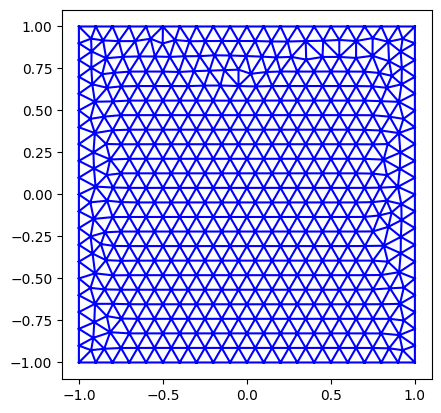

In [ ]:
from mesh import create_2d_square

mesh2 = create_2d_square(
    half_width=1.0,
    origin=(0.0, 0.0),
    mesh_size=1
)

mesh2.plot()